# f-GAN: Training Generative Neural Samplers using Variational Divergence Minimization

In the [last note](Week%201.%20Generative%20Adversarial%20Networks.ipynb), we saw how to learn a distribution $p_g$ that approximated some unknown distribution $p_d$. We did this by introducing two neural networks. Namely, the generator and the discriminator, which were both neural networks. The discriminator and the generator played a game where the discriminator were to distinguish between real data sampled from $p_d$ and fake data sampled from the generator. The generator, on the other hand, were to fool the discriminator by transforming random noise $z_i \sim \mathcal{N}(0, 1)$ into something indistinguishable from the real data.

In essence, fooling the discriminator corresponds to minimizing the "distance" between $p_d$ and $p_g$ for some notion of distance. We presented the [Kullbach-Liebler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) as one such measure and argued that we were not able to calculate this measure for several reasons. The divergence is defined as

$$
D_{KL}(P || Q) = \int_\mathcal{X} p(x) \log \frac{p(x)}{q(x)} dx
$$

over the domain $\mathcal{X}$ for continuous probability density functions $p$ and $q$. As we could not calculate this directly, we introduced the discriminator in order to be able to opgimize the generator. More formally, the discriminato played the following game:

$$
\text{min }_g\text{ max}_d\; \mathbb{E}_{x\sim p_d}[\text{log d(x)}] + \mathbb{E}_{z \sim p_z}[1-\text{log(d(g(z))}] \quad \quad (1)
$$

When playing this game, [[3]](#References) showed that under certain constraints, the optimal
discriminator $d^\ast_g(x)$ is the following

$$
d^\ast_g(x) = \frac{p_{data}(x)}{p_{data}(x) + p_g(x)}. \quad \quad (2)
$$

Further more, it turned out that playing this game would approximately minimize the [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence)

$$
D_{JS}(P || Q) = D_{KL}(P ||P + Q) + D_{KL}(Q || P + Q). \quad \quad (3)
$$

The goal of this note is to generalize Eqn. (3) to a broader class of divergences. Conceptually, this will allow us to "change the cost function" (which is essentially Eqn. (1)). It will also generalize Eqn. (2) such that the optimal discriminator will get different forms according to which divergence the GAN setup is minimizing.

A simple motivation for why we may want to change the objective of the training is the gif in Figure 1, which is very similar to the one we saw last week. The only difference is that the real data now comes from a multi-modal distribution. The figure shows how the learned distribution (which is now underspecified since it can only represent "simple" uni-modal distribution) may learn to simply span the two modes of the data. It may be that we would rather want the generater to just focus on one of the modes of the true distribution. In that case we could hope that a change in traning objective would favour such a property.

<div style="text-align: center;">
    <img src="gifs/dual-mode/gif.gif">
    <strong>Figure 1</strong> Animation of how $p_g$ converges towards $p_d$.
</div>



<IPython.core.display.Javascript object>


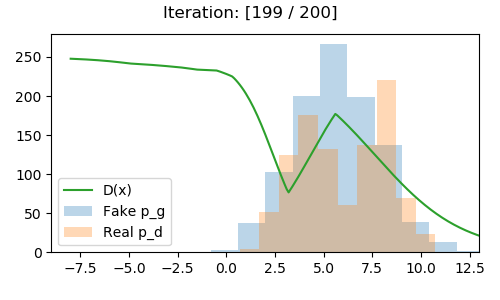

/home/fhv/anaconda3/envs/ml18/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [26]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

n       = 1000
x1      = np.random.normal(0, 1, size=(n, 1))
x2      = np.random.normal(4, 1, size=(n, 1))
x       = np.c_[x1, x2].reshape(-1, 1)

fig, ax = plt.subplots(figsize=(5, 3))

def plot(): 
    ax.cla()
    ax.hist(generator.predict_on_batch(noise) , alpha=0.3, label="Fake p_g")
    ax.hist(real_data , alpha=0.3, label="Real p_d")
    xs = np.arange(-8, 16, 0.1)
    pred = discriminator.predict_on_batch(xs)
    ax.plot(xs, pred*250, label="D(x)")
    ax.legend(loc=3)
    ax.set_ylim([0, 280])
    ax.set_xlim([-9, 13])
    
    fig.suptitle("Iteration: [%i / %i]"%(i, iterations))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.canvas.draw()
    plt.savefig("gifs/dual-mode/%i.png"%i)
    plt.pause(.01)

# number of samples. 
n = 1000
iterations = 200
repeat = 10

# define generator
generator = Sequential()
generator.add(Dense(1, input_dim=1)) # one neuron except bias, don't have the relu activation!
#generator.add(Dense(1))

# define discrimiantor
discriminator = Sequential()
discriminator.add(Dense(10, input_dim=1, activation="relu")) # non linearity has some use here. 
discriminator.add(Dense(1,  activation="sigmoid"))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.005))

# Combine models
gan = Sequential()
gan.add(generator)
discriminator.trainable = False # from the gan model we freeze discriminator to use it as loss function
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.005))

# Do several updates, plot some interval of iterations fake / real data. 
for i in range(iterations):
    noise     = np.random.normal(0, 1, size=(n, 1))
    fake_data = generator.predict_on_batch(noise)
    
    x1        = np.random.normal(4, 1, size=(n//2, 1))
    x2        = np.random.normal(8, 1, size=(n//2, 1))
    real_data = np.c_[x1, x2].reshape(-1, 1)
    
    disc_X = np.concatenate((real_data, fake_data), axis=0)
    disc_y = np.concatenate((np.zeros(n), np.ones(n)), axis=0) # flip labels since we min instead of max. 
    
    plot()
    for j in range(repeat): discriminator.train_on_batch(x=disc_X, y=disc_y)
    for j in range(repeat): gan.train_on_batch(x=noise, y=np.zeros(n))


# References
[[1]](http://papers.nips.cc/paper/6066-f-gan-training-generative-neural-samplers-using-variational-divergence-minimization.pdf) Nowozin, S., Cseke, B. and Tomioka, R., 2016. f-gan: Training generative neural samplers using variational divergence minimization. In Advances in Neural Information Processing Systems (pp. 271-279).

[[2]](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5605355) Nguyen, X., Wainwright, M.J. and Jordan, M.I., 2010. Estimating divergence functionals and the likelihood ratio by convex risk minimization. IEEE Transactions on Information Theory, 56(11), pp.5847-5861.

[[3]](https://papers.nips.cc/paper/5423-generative-adversarial-nets) Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A. and Bengio, Y., 2014. Generative adversarial nets. In Advances in neural information processing systems (pp. 2672-2680).